<a href="https://colab.research.google.com/github/thecodecook/sk_parliamentary_speech_analysis/blob/main/Political_speech_analysis_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup


In [ ]:
# @title Install dependencies

%pip install -U langchain-google-genai
%pip install -U langchain-openai
%pip install -U langchain-anthropic
%pip install -U langchain-deepseek

%pip install tiktoken
%pip install --upgrade google-cloud-aiplatform[tokenization]

In [4]:
# @title Load data

import pandas as pd

df_speech = pd.read_csv('speech.csv', parse_dates=['timestamp'])
df_parliament_members = pd.read_csv('poslanci-strana-klub.csv')

df_speech

,id,meeting_id,timestamp,speaker,speech_text,video_verified,video_start,video_stop
0,296956,9001,2023-10-25 09:55:00,Juraj Blanár,Sľubujem. (Potlesk.),1,0,920
1,296960,9001,2023-10-25 09:55:00,Gábor Grendel,Sľubujem. (Potlesk.),1,0,920
2,296964,9001,2023-10-25 09:55:00,Marián Viskupič,Sľubujem. (Potlesk.),1,0,921
3,296897,9001,2023-10-25 10:10:00,Tomáš Szalay,Sľubujem. (Potlesk.),1,900,1820
4,296899,9001,2023-10-25 10:10:00,Richard Sulík,Sľubujem. (Potlesk.),1,900,1820
...,...,...,...,...,...,...,...,...
17637,342000,9033,2025-04-16 16:59:00,Ján Hargaš,"Kolegyne, kolegovia, ďakujem všetkým za faktic...",0,10799,11719
17638,338424,9034,2025-04-01 07:59:00,Tibor Gašpar,"Vážené panie poslankyne, vážení páni poslanci,...",1,0,919
17639,338426,9034,2025-04-01 08:29:00,Tibor Gašpar,"Panie poslankyne, páni poslanci, prosím, aby s...",1,1799,2170
17640,338891,9034,2025-04-02 09:01:00,Andrej Danko,(Pre technické problémy a nefunkčnosť mikrofón...,1,19,20


In [5]:
# @title Unique speakers and their speeches

speaker_counts = df_speech['speaker'].value_counts()
speaker_counts_df = speaker_counts.reset_index()
speaker_counts_df.columns = ['Unique Speakers', 'Counts']
speaker_counts_df

,Unique Speakers,Counts
0,Jozef Pročko,859
1,Ondrej Dostál,770
2,Gábor Grendel,395
3,Igor Matovič,344
4,Zuzana Števulová,336
...,...,...
189,Dušan Galis,1
190,Michal Lukša,1
191,Boleslav Lešo,1
192,Peter Sokol,1


In [6]:
# @title Some were not elected in elections...

speakers_speech = set(df_speech['speaker'].unique())
speakers_poslanci = set(df_parliament_members['Meno a priezvisko'].unique())

missing_speakers = speakers_speech - speakers_poslanci

missing_speakers_df = pd.DataFrame(list(missing_speakers), columns=['Name'])
missing_speakers_df

,Name
0,Ľubomír Andrassy
1,Renáta Bláhová
2,Zuzana Čaputová
3,Zuzana Dlugošová
4,Zuzana Stavrovská
5,Miroslav Radačovský
6,Maroš Žilinka
7,Martina Bajo Holečková
8,Ján Tóth
9,Marta Danielová


In [21]:
# @title ...so we remove them for purpose of this analysis

names_to_remove = missing_speakers_df['Name'].tolist()

df_chosen_speech = df_speech[~df_speech['speaker'].isin(names_to_remove)]
df_chosen_speech = df_chosen_speech.reset_index(drop=True)

speaker_counts = df_chosen_speech['speaker'].value_counts()
speaker_counts_df = speaker_counts.reset_index()
speaker_counts_df.columns = ['Unique Speakers', 'Counts']
speaker_counts_df

,Unique Speakers,Counts
0,Jozef Pročko,859
1,Ondrej Dostál,770
2,Gábor Grendel,395
3,Igor Matovič,344
4,Zuzana Števulová,336
...,...,...
170,Dušan Galis,1
171,Boleslav Lešo,1
172,Michal Lukša,1
173,Peter Sokol,1


Average speech length: 2531.961523046092
Minimum speech length: 1
Maximum speech length: 171832
0    Sľubujem. (Potlesk.)
1    Sľubujem. (Potlesk.)
2    Sľubujem. (Potlesk.)
3    Sľubujem. (Potlesk.)
4    Sľubujem. (Potlesk.)
Name: speech_text, dtype: object


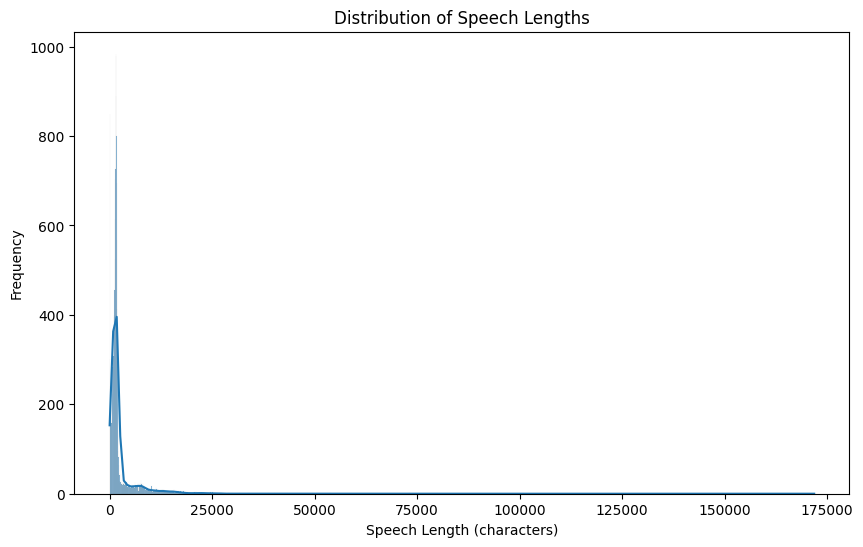

In [22]:
# @title Speech length by characters

import matplotlib.pyplot as plt
import seaborn as sns

df_chosen_speech['speech_length'] = df_chosen_speech['speech_text'].str.len()
print(f"Average speech length: {df_chosen_speech['speech_length'].mean()}")
print(f"Minimum speech length: {df_chosen_speech['speech_length'].min()}")
print(f"Maximum speech length: {df_chosen_speech['speech_length'].max()}")
print(df_chosen_speech['speech_text'].head())

plt.figure(figsize=(10, 6))
sns.histplot(df_chosen_speech['speech_length'], kde=True)
plt.title('Distribution of Speech Lengths')
plt.xlabel('Speech Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [23]:
# @title Speakers that spoke less than 200 characters

speaker_total_lengths = df_chosen_speech.groupby('speaker')['speech_length'].sum()
speakers_under_200 = speaker_total_lengths[speaker_total_lengths < 300]

for speaker in speakers_under_200.index:
  speaker_speeches = df_chosen_speech[df_chosen_speech['speaker'] == speaker]
  print(f"Speeches by {speaker}:")
  for index, row in speaker_speeches.iterrows():
    print(row['speech_text'])
  print("-" * 20) # Separator between speakers


Speeches by Igor Melicher:
Sľubujem. (Potlesk.)
--------------------
Speeches by Jozef Kačmár:
Ďakujem, pán predsedajúci. To isté, pri hlasovaní 140, zákone o pedagogických zamestnancov, mi nezaznamenalo hlasovanie. Hlasoval som za.
--------------------
Speeches by Juraj Gedra:
Sľubujem. (Potlesk.)
--------------------
Speeches by Lucia Kurilovská:
Ďakujem veľmi pekne za dôveru, vážené dámy, vážení páni, je mi to ľúto, ale tiež budeme zasadať ihneď po skončení zasadnutia, náš Výbor Národnej rady pre vzdelávanie, vedu, mládež a šport, miestnosť č. 33 na prízemí.
--------------------
Speeches by Peter Sokol:
Ďakujem veľmi pekne. Ja si myslím, že pán predseda vystihol aktuálnosť a vážnosť tejto témy v plnom rozsahu, čiže ďakujeme všetci.
--------------------


In [24]:
# @title We'll only work with speeches longer than 200 characters, to remove the most formal stuff

df_chosen_speech = df_chosen_speech[df_chosen_speech['speech_length'] >= 200]
df_chosen_speech = df_chosen_speech[df_chosen_speech['id'] != 296957]
df_chosen_speech = df_chosen_speech.reset_index(drop=True)
df_chosen_speech.shape

(16032, 9)

## LLM setup

In [25]:
# @title Add number of tokens (gemini 1.5 tokenizer)

from vertexai.preview import tokenization

def count_tokens(text):
    return tokenizer.count_tokens(text).total_tokens

tokenizer = tokenization.get_tokenizer_for_model("gemini-1.5-flash-002")

df_chosen_speech['num_tokens'] = df_chosen_speech['speech_text'].apply(count_tokens)
display(df_chosen_speech.shape)

(16032, 10)

count    16032.000000
mean       896.345434
std       1530.399652
min         62.000000
25%        382.000000
50%        498.000000
75%        613.000000
max      68808.000000
Name: num_tokens, dtype: float64


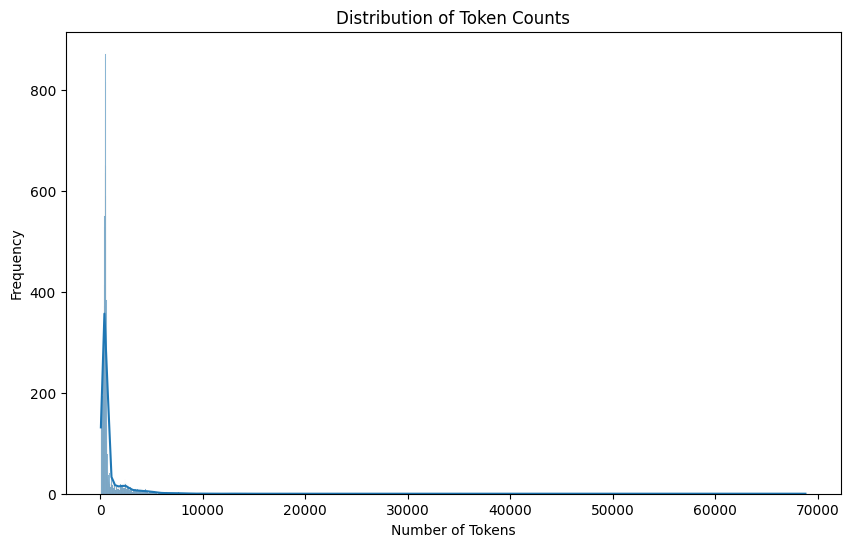

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# @title Display basic statistics about the 'num_tokens' column
print(df_chosen_speech['num_tokens'].describe())

# Display the distribution of token counts using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_chosen_speech['num_tokens'], kde=True)
plt.title('Distribution of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()


In [27]:
# @title Filter the DataFrame to include only rows where 'num_tokens' is less than 20000
df_chosen_speech = df_chosen_speech[df_chosen_speech['num_tokens'] < 20000]
df_chosen_speech

,id,meeting_id,timestamp,speaker,speech_text,video_verified,video_start,video_stop,speech_length,num_tokens
0,296971,9001,2023-10-25 12:40:00,Marián Viskupič,"Ďakujem pekne za slovo, pán predseda. Zápisnic...",1,9900,10820,1403,476
1,296976,9001,2023-10-25 12:40:00,Marián Viskupič,"Pardon, musíme sa naučiť všetci. Teda zápisnic...",1,9900,10820,1398,468
2,296983,9001,2023-10-25 12:40:00,Marián Saloň,"Ďakujem veľmi pekne, pán predseda. V prvom rad...",1,9900,10820,295,95
3,296990,9001,2023-10-25 13:10:00,Marián Saloň,Takže funguje. Ja sa pokúsim čo najrýchlejšie ...,1,11700,12620,6760,2239
4,296969,9001,2023-10-25 13:25:00,Igor Matovič,"Aha, asi sa počujeme už, že? Dobre. Ja som si ...",1,12600,13520,7404,2480
...,...,...,...,...,...,...,...,...,...,...
16027,342000,9033,2025-04-16 16:59:00,Ján Hargaš,"Kolegyne, kolegovia, ďakujem všetkým za faktic...",0,10799,11719,1819,583
16028,338424,9034,2025-04-01 07:59:00,Tibor Gašpar,"Vážené panie poslankyne, vážení páni poslanci,...",1,0,919,1149,389
16029,338426,9034,2025-04-01 08:29:00,Tibor Gašpar,"Panie poslankyne, páni poslanci, prosím, aby s...",1,1799,2170,558,214
16030,338891,9034,2025-04-02 09:01:00,Andrej Danko,(Pre technické problémy a nefunkčnosť mikrofón...,1,19,20,3431,1179


count    16024.000000
mean       879.085622
std       1274.591491
min         62.000000
25%        382.000000
50%        498.000000
75%        613.000000
max      18471.000000
Name: num_tokens, dtype: float64


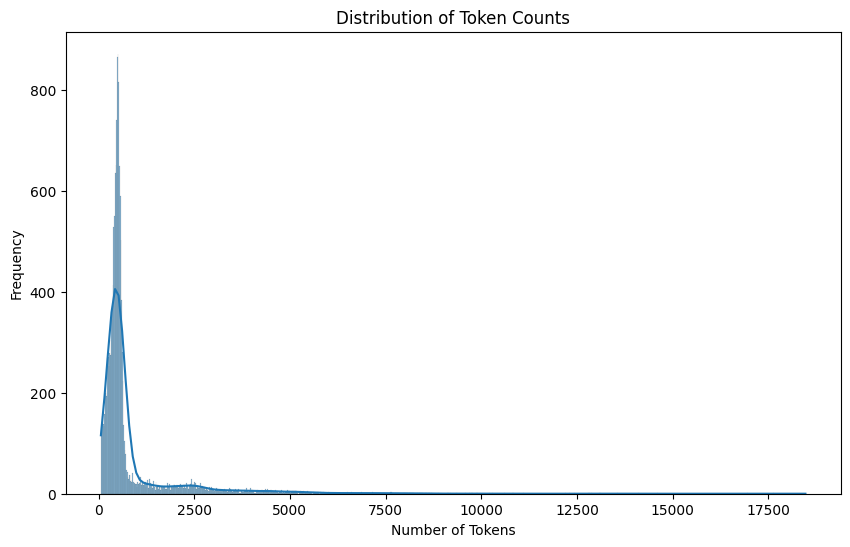

In [30]:
# @title Display basic statistics about the 'num_tokens' column after filter
print(df_chosen_speech['num_tokens'].describe())

# Display the distribution of token counts using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_chosen_speech['num_tokens'], kde=True)
plt.title('Distribution of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()


## LLM processing for topics/idioms


In [32]:
# @title Prepare data df for classificaiton

pd.options.mode.chained_assignment = None  # default='warn'

df = df_chosen_speech.copy()
df

,id,meeting_id,timestamp,speaker,speech_text,video_verified,video_start,video_stop,speech_length,num_tokens
0,296971,9001,2023-10-25 12:40:00,Marián Viskupič,"Ďakujem pekne za slovo, pán predseda. Zápisnic...",1,9900,10820,1403,476
1,296976,9001,2023-10-25 12:40:00,Marián Viskupič,"Pardon, musíme sa naučiť všetci. Teda zápisnic...",1,9900,10820,1398,468
2,296983,9001,2023-10-25 12:40:00,Marián Saloň,"Ďakujem veľmi pekne, pán predseda. V prvom rad...",1,9900,10820,295,95
3,296990,9001,2023-10-25 13:10:00,Marián Saloň,Takže funguje. Ja sa pokúsim čo najrýchlejšie ...,1,11700,12620,6760,2239
4,296969,9001,2023-10-25 13:25:00,Igor Matovič,"Aha, asi sa počujeme už, že? Dobre. Ja som si ...",1,12600,13520,7404,2480
...,...,...,...,...,...,...,...,...,...,...
16027,342000,9033,2025-04-16 16:59:00,Ján Hargaš,"Kolegyne, kolegovia, ďakujem všetkým za faktic...",0,10799,11719,1819,583
16028,338424,9034,2025-04-01 07:59:00,Tibor Gašpar,"Vážené panie poslankyne, vážení páni poslanci,...",1,0,919,1149,389
16029,338426,9034,2025-04-01 08:29:00,Tibor Gašpar,"Panie poslankyne, páni poslanci, prosím, aby s...",1,1799,2170,558,214
16030,338891,9034,2025-04-02 09:01:00,Andrej Danko,(Pre technické problémy a nefunkčnosť mikrofón...,1,19,20,3431,1179


In [34]:
# @title Prepare classification prompt

import glob
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
import pandas as pd
import tiktoken
import time
from tqdm.notebook import tqdm
from os.path import isfile
from google.colab import userdata
import getpass
import os
from vertexai.preview import tokenization

API_KEY = userdata.get('GOOGLE_API_KEY')

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = API_KEY

API_MODEL = 'gemini-2.5-flash-preview-04-17'


tagging_prompt = ChatPromptTemplate.from_template(
    """
    Si politický, kultúrny, sociologický špecialista, ktorý klasifikuje prejavy v parlamente.

    Budeš čítať texty, ktoré sú v slovenskom jazyku.

    Následne ich klasifikuješ pomocou jedného slova alebo krátkej frázy,
    pričom budeš brať do úvahy témy, ktoré sa zvyčajne preberajú v slovenskom parlamente.

    Medzi príkladové témy patria: „voľby“, „klíma“, „vojna“, „technológie“,
    „inovácie“, „financie“, „migrácia“, „priemysel“, „demokracia“,
    „práva menšín“, "potrat", „náboženstvo“, „korupcia“.
    Tento zoznam nie je úplný.

    Jeden prejav môže zahŕňať viacero tém. V prípade potreby ho klasifikuj
    pomocou viacerých značiek oddelených bodkočiarkou.
    Čím menej ale presných značiek uvedieš, tým lepšie.

    Tiež zaznamenáš, či text obsahuje klišé, idiomy alebo frázy,
    ktoré sú bežne používané v slovenskej politike.
    Toto pole môže zostať prázdne, ak také idiomy nie sú prítomné v danom texte.
    Zahrň len také idiomy, ktoré sa doslovne nachádzajú v poskytnutom texte,
    nie žiadne iné.


    1. Ukážkový vstup by bol:


    ```Ďakujem pekne. Pán Hazucha, ja tak rozmýšľam, že vy, či ste sa medzičasom stali
    odborníkom nielen na jednorodičovské rodiny, ale aj na lesy.
    A celkovo mám taký pocit, že s pánom Kalivodom ste ma vôbec nepočúvali,
    lebo ja som predsa hovorila o chránených územiach, kde aj zo zákona, či chcete,
    či nechcete, má byť prioritou ochrana prírody, nie ťažba dreva.```

    A ukážkový výstup by bol:

    topic: lesy, životné prostredie
    idioms:

    2. Ďalší ukážkový vstup by bol:


    ``` No ja, ako som to tu počúval, ja som za to, aby sa vyšetrili všetky kauzy,
    lebo naozaj padni komu padni a keď ten Kiska bol daňový podvodník,
    čo si ja nemyslím, lebo Andreja Kisku ja nepoznám osobne,
    ale naozaj viem o tom, že dával tie peniaze, dával.```

    A ukážkový výstup by bol:

    topic: daňový podvod, prezident Kiska
    idioms: padni komu padni


    Text na preklad je uvedený nižšie:

    ---
    {text}.
    """
)

class Classification(BaseModel):
    topic: str = Field(description="The main topic of the text")
    idioms: str = Field(description="The commonly used clichés, idioms, and phrases")

# LLM
llm = ChatGoogleGenerativeAI(temperature=0.1,
                 model=API_MODEL).with_structured_output(
    Classification
)

tagging_chain = tagging_prompt | llm

In [ ]:
# @title Classify topics/idioms, simple chunk split with some timeout, adjust if needed / rate limited

def split_dataframe(df, chunk_size=30):
    return [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]


chunk_size = 100

dfs = split_dataframe(df, chunk_size=chunk_size)
for i, subset_result in enumerate(tqdm(dfs)):

    fname = f"./classified-texts/{chunk_size}_{i+1}.csv"
    if isfile(fname):
        continue

    results = tagging_chain.batch([{'text': text} for text in subset_result['speech_text']],
                          config={"max_concurrency": 70})

    subset_result['topic'] = [result.topic for result in results]
    subset_result['idioms'] = [result.idioms for result in results]
    subset_result.to_csv(fname)

    if i % 20 == 0:
        time.sleep(30)

## LLM processing for political views classification

In [35]:
# @title Prepare data for scoring, less than 10k tokens, more than 200 tokens, at least 5 speeches per person

# Filter for num_tokens between 200 and 20000
df = df_chosen_speech[(df_chosen_speech['num_tokens'] >= 200) & (df_chosen_speech['num_tokens'] <= 10000)]

# Remove id 296957
df = df[df['id'] != 296957]

# Remove speakers with less than 5 speeches
speaker_counts = df['speaker'].value_counts()
speakers_to_keep = speaker_counts[speaker_counts >= 5].index
df = df[df['speaker'].isin(speakers_to_keep)]

df = df.reset_index(drop=True)
df

,id,meeting_id,timestamp,speaker,speech_text,video_verified,video_start,video_stop,speech_length,num_tokens
0,296971,9001,2023-10-25 12:40:00,Marián Viskupič,"Ďakujem pekne za slovo, pán predseda. Zápisnic...",1,9900,10820,1403,476
1,296976,9001,2023-10-25 12:40:00,Marián Viskupič,"Pardon, musíme sa naučiť všetci. Teda zápisnic...",1,9900,10820,1398,468
2,296990,9001,2023-10-25 13:10:00,Marián Saloň,Takže funguje. Ja sa pokúsim čo najrýchlejšie ...,1,11700,12620,6760,2239
3,296969,9001,2023-10-25 13:25:00,Igor Matovič,"Aha, asi sa počujeme už, že? Dobre. Ja som si ...",1,12600,13520,7404,2480
4,296997,9001,2023-10-25 13:25:00,Matúš Šutaj Eštok,"Ďakujem pekne. Musím povedať, že nie je nič ús...",1,12600,13520,1482,480
...,...,...,...,...,...,...,...,...,...,...
14801,342000,9033,2025-04-16 16:59:00,Ján Hargaš,"Kolegyne, kolegovia, ďakujem všetkým za faktic...",0,10799,11719,1819,583
14802,338424,9034,2025-04-01 07:59:00,Tibor Gašpar,"Vážené panie poslankyne, vážení páni poslanci,...",1,0,919,1149,389
14803,338426,9034,2025-04-01 08:29:00,Tibor Gašpar,"Panie poslankyne, páni poslanci, prosím, aby s...",1,1799,2170,558,214
14804,338891,9034,2025-04-02 09:01:00,Andrej Danko,(Pre technické problémy a nefunkčnosť mikrofón...,1,19,20,3431,1179


In [39]:
# @title Setup chosen LLM models

import glob
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field, ConfigDict, SecretStr
import pandas as pd
import tiktoken
import time
from tqdm.notebook import tqdm
from os.path import isfile
from google.colab import userdata
import getpass
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_deepseek import ChatDeepSeek
from langchain_core.utils.utils import secret_from_env
from typing import Optional


if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

if not os.environ.get("ANTHROPIC_API_KEY"):
    os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')

if not os.environ.get("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = userdata.get('DEEPSEEK_API_KEY')

if not os.environ.get("OPENROUTER_API_KEY"):
    os.environ["OPENROUTER_API_KEY"] = userdata.get('OPENROUTER_API_KEY')


class ChatOpenRouter(ChatOpenAI):
    openai_api_key: Optional[SecretStr] = Field(
        alias="api_key",
        default_factory=secret_from_env("OPENROUTER_API_KEY", default=None),
    )
    @property
    def lc_secrets(self) -> dict[str, str]:
        return {"openai_api_key": "OPENROUTER_API_KEY"}

    def __init__(self,
                 openai_api_key: Optional[str] = None,
                 **kwargs):
        openai_api_key = (
            openai_api_key or os.environ.get("OPENROUTER_API_KEY")
        )
        super().__init__(
            base_url="https://openrouter.ai/api/v1",
            openai_api_key=openai_api_key,
            **kwargs
        )


chosen_models = {
    'gemini': ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-04-17", temperature=0.1),
    'claude': ChatAnthropic(model="claude-3-5-haiku-latest", temperature=0.1),
    'openai': ChatOpenAI(model="gpt-4.1-mini-2025-04-14", temperature=0.1),
    'deepseek': ChatDeepSeek(model="deepseek-chat", temperature=0.1),
    'gpt-41mini-bkp': ChatOpenRouter(model="openai/gpt-4.1-mini", temperature=0.1, max_tokens=200),
    'claude-35haiku-bkp': ChatOpenRouter(model="anthropic/claude-3.5-haiku", temperature=0.1, max_tokens=200)
}

In [37]:
# @title Setup input data splitting for batch processing, splitting by token counts needed


import pandas as pd


def split_dataframe(df, chunk_size=20):
    return [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]


def split_dataframe_by_tokens(df, max_tokens=25000, prompt_length = 600):
    """
    Splits a DataFrame into parts based on the sum of 'num_tokens' column.

    Args:
        df: The input pandas DataFrame with a 'num_tokens' column.
        max_tokens: The maximum allowed sum of 'num_tokens' for each part.

    Returns:
        A list of DataFrames, where each DataFrame has a total of at most max_tokens.
    """
    parts = []
    current_part = pd.DataFrame()
    current_token_sum = 0

    for index, row in df.iterrows():
        row_tokens = row['num_tokens'] + prompt_length

        if current_token_sum + row_tokens <= max_tokens:
            current_part = pd.concat([current_part, row.to_frame().T])
            current_token_sum += row_tokens
        else:
            if not current_part.empty:
                parts.append(current_part)
            current_part = row.to_frame().T
            current_token_sum = row_tokens

    if not current_part.empty:
        parts.append(current_part)

    return parts

In [40]:
# @title Prepare scoring prompt

from pydantic import BaseModel, Field, ConfigDict

pd.options.mode.chained_assignment = None  # default='warn'

tagging_prompt = ChatPromptTemplate.from_template(
    """
    Si politický, kultúrny a sociologický špecialista, ktorý klasifikuje prejavy v parlamente.

    Budeš čítať texty v slovenskom jazyku.

    Následne ich ohodnotíš na základe troch vybraných dimenzií pomocou skóre od 0 po 100.
    Skóre pre každú dimenziu by malo odrážať postoj rečníka nie tvoj názor.
    Ak text nemá ohodnotiteľný obsah pre danú dimenziu, tak uveď skóre "NA".

    Dimenzie spolu s neúplnými príkladmi tém sú nasledovné:
    1. sociocultural: Liberálny vs. Konzervatívny
       * Liberálny pól: Kladiem dôraz na individuálnu slobodu, práva menšín,
         otvorenosť voči spoločenským zmenám, sekularizmus, progresívne pohľady na rodinu, reprodukčné práva.
       * Konzervatívny pól: Kladiem dôraz na tradíciu, kresťanské hodnoty,
         tradičnú rodinu, rolu cirkvi v spoločnosti, odpor voči právam LGBTI+,
         obmedzenia reprodukčných práv, obozretnosť voči spoločenským zmenám.
       + Skóre 0 znamená extrémny Liberálny postoj a skóre 100 extrémny Konzervatívny postoj.

    2. geopolitical: Prozápadný vs. (Provýchodný / Suverenistický)
       * Prozápadný pól: Jasná orientácia na členstvo v EÚ a NATO, dôraz na spojenectvo s USA a západnými krajinami,
         podpora Ukrajiny, vnímanie Ruska ako hrozby, dôvera v medzinárodné inštitúcie.
       * Provýchodný / Suverenistický pól: Skepticizmus voči EÚ a NATO,
         dôraz na národnú suverenitu, lepšie vzťahy s Ruskom,
         kritika USA, šírenie dezinformácií, nedôvera v západné inštitúcie.
       + Skóre 0 znamená extrémny Prozápadný postoj a skóre 100 extrémny Provýchodný postoj.

    3. corruption: (Zástancovia vymožiteľnosti práva a transparentnosti) vs. (Status quo / Akceptácia klientelizmu)
       * Zástancovia vymožiteľnosti práva a transparentnosti: Dôraz na nezávislosť súdnictva a prokuratúry,
         boj proti korupcii a klientelizmu, transparentnosť verejnej správy, zodpovednosť politikov.
       * Status quo / Akceptácia klientelizmu: Tendencia oslabovať nezávislé kontrolné orgány (polícia, prokuratúra, súdy),
         bagatelizovať korupciu, preferovať lojalitu pred odbornosťou, udržiavať systémy klientelizmu a "našich ľudí".
       + Skóre 0: Prejav silne kritizuje korupciu, klientelizmus a netransparentné praktiky a podporuje vymožiteľnosť práva a transparentnosť.
       + Skóre 100: Prejav obhajuje alebo akceptuje korupciu, klientelizmus a netransparentné praktiky, alebo odmieta snahy o vymožiteľnosť práva a transparentnosť.



    Do výstupu uveď len hodnotenie a nič iné. Ukážkový výstup:


    sociocultural: 15
    geopolitical: NA
    corruption: 5


    Text na hodnotenie je uvedený nižšie:

    ---
    {text}.
    """
)

class Classification(BaseModel):
    model_config = ConfigDict(coerce_numbers_to_str=True)

    sociocultural: str = Field(description="The sociocultural score")
    geopolitical: str = Field(description="The geopolitical score")
    corruption: str = Field(description="The corruption score")

# LLM
chosen_model = 'claude-35haiku-bkp'
llm = chosen_models[chosen_model].with_structured_output(Classification)
tagging_chain = tagging_prompt | llm


In [ ]:
# @title Classify politicians by their views

from types import SimpleNamespace

chunk_size = 10

dfs = split_dataframe(df, chunk_size=chunk_size)
#dfs = split_dataframe_by_tokens(df, 30000)

for i, subset_result in enumerate(tqdm(dfs)):

    fname = f"./{chosen_model}-scored/{chunk_size}_{i+1}.csv"
    if isfile(fname):
        continue

    results = tagging_chain.batch([{'text': text} for text in subset_result['speech_text']],
                          config={"max_concurrency": 70})

    default_result_data = {'sociocultural': 'NA', 'geopolitical': 'NA', 'corruption': 'NA'}
    default_obj = SimpleNamespace(**default_result_data)

    results = [default_obj if r is None else r for r in results]

    subset_result['sociocultural'] = [result.sociocultural for result in results]
    subset_result['geopolitical'] = [result.geopolitical for result in results]
    subset_result['corruption'] = [result.corruption for result in results]

    subset_result.to_csv(fname)

    time.sleep(10)

In [ ]:
# @title Classify politicians by their views (if structural output error with claude)

from types import SimpleNamespace

from pydantic import ValidationError
from langchain_core.exceptions import LangChainException
import re

chunk_size = 50

dfs = split_dataframe(df, chunk_size=chunk_size)
#dfs = split_dataframe_by_tokens(df, 30000)

for i, subset_result in enumerate(tqdm(dfs)):

    # Ensure the directory exists
    dirpath = f"./{chosen_model}-scored/"
    os.makedirs(dirpath, exist_ok=True)
    fname = f"{dirpath}{chunk_size}_{i+1}.csv"
    if isfile(fname):
        print(f"Skipping {fname}, already exists.")
        continue

    # This will return an exception object for inputs that failed
    results = tagging_chain.batch(
        [{'text': text} for text in subset_result['speech_text']],
        config={"max_concurrency": 70},
        return_exceptions=True
    )

    processed_results = []
    for j, result in enumerate(results):
        default_data = {'sociocultural': 'NA', 'geopolitical': 'NA', 'corruption': 'NA'}
        default_obj = SimpleNamespace(**default_data)

        if isinstance(result, ValidationError):
            print(f"Validation error for id {subset_result.iloc[j]['id']}: {result}")
            # Attempt to parse the non-JSON output by accessing the input from the error details
            try:
                error_input_value = result.errors()[0].get('input')
                if error_input_value:
                    # The input_value is a string like 'sociocultural: 30\ngeopolitical: NA\ncorruption: 40'
                    # We can split by newline and then by ': '
                    lines = str(error_input_value).strip().split('\n')
                    parsed_data = {}
                    for line in lines:
                        match = re.match(r'^\s*([^:]+):\s*(.*)\s*$', line)
                        if match:
                            key = match.group(1).strip()
                            value = match.group(2).strip()
                            if key in default_data:
                                 parsed_data[key] = value

                    default_obj.sociocultural = parsed_data.get('sociocultural', 'NA')
                    default_obj.geopolitical = parsed_data.get('geopolitical', 'NA')
                    default_obj.corruption = parsed_data.get('corruption', 'NA')
                    processed_results.append(default_obj)
                else:
                     print(f"Input value not found in ValidationError details for id {subset_result.iloc[j]['id']}")
                     processed_results.append(default_obj)

            except Exception as parse_error:
                print(f"Failed to parse validation error input for id {subset_result.iloc[j]['id']}: {parse_error}")
                processed_results.append(default_obj) # Append default NA default_object
        elif isinstance(result, (LangChainException, Exception)):
             print(f"Error processing id {subset_result.iloc[j]['id']}: {result}")
             processed_results.append(default_obj)
        elif result is None:
             print(f"Model returned None for id {subset_result.iloc[j]['id']}")
             processed_results.append(default_obj)
        else:
            processed_results.append(result)

    subset_result['sociocultural'] = [result.sociocultural for result in processed_results]
    subset_result['geopolitical'] = [result.geopolitical for result in processed_results]
    subset_result['corruption'] = [result.corruption for result in processed_results]

    subset_result.to_csv(fname, index=False)

    time.sleep(10)